<a href="https://colab.research.google.com/github/tanay2/NeighborJoiningDistanceMetrics/blob/main/NeighborJoining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start by importing what we need for neighbor join and also biopython. Biopython is the extremely important library that will be used for scoring metrics and visualization of neighbor joining.

In [382]:
! pip install nose

#https://biopython.org/wiki/Phylo
#https://biopython-tutorial.readthedocs.io/en/latest/notebooks/13%20-%20Phylogenetics%20with%20Bio.Phylo.html
!pip install biopython

import nose.tools as nt
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We start by copying over the neighor joining algorithm from HW3.

In [383]:
def check_tree(D,T):
    """
    Implement floyd-warshall algorithm on the graph defined in T
    
    """
    
    V = len(T)
    dT = [[float("inf") for i in range(V)] for j in range(V)]
    n = (V + 2)//2
    
    # Length check
    if n!=len(D):
        print("fail")
        return False
    
    # fill in existing edges
    for k in T:
        for l in T[k]:
            dT[k][l] = T[k][l]
            dT[l][k] = T[l][k]
    
    # fill in the diagonal elements 
    for i in range(len(dT)):
        dT[i][i] = 0.0
    
    # relax edges 
    for k in range(V):
        for i in range(V):
            for j in range(V):
                if dT[i][j] > dT[i][k] + dT[k][j]:
                    dT[i][j] = dT[i][k] + dT[k][j]
                    dT[j][i] = dT[i][j]
    
    # Check each value in dT
    for i in range(n):
        for j in range(n):
            if D[i][j] != dT[i][j]:
                print("fail2")
                return False
    return True

def min_S_value(D, u):
    """
    returns the value (i,j) for which 
    (m-2)*D[i][j] - u_i - u_j is minimum
    """
    m = len(D)
    min_S, min_i, min_j = float("inf"),-1,-1
    for k in D:
        for l in D[k]:
            if l!=k:
                crit = (m-2)*D[k][l] - u[k] - u[l]
                if crit < min_S:
                    min_S = crit
                    min_i = k
                    min_j = l
    return (min_i, min_j)


def neighbor_join(D):
    """
    Takes a distance matrix D, and returns the tree T 
    consistent with the closest additive matrix D' to D.
    
    :param: D is a dict of dicts representing pairwise distances between leaves
    :return: a dict of dicts that contains all the edges with their weights in the tree defined by D'.    
    """
    
    T = {}
    r = len(D)
    for i in range(r):
      T[i] = {}
    while len(D)>2:
        u = {}
        for i in D:
          u[i] = 0
          for j in D[i]:
            u[i] += D[i][j]
        min_i, min_j = min_S_value(D, u)
        T[r] = {}
        T[r][min_i] = 0.5*(D[min_i][min_j] + (u[min_i] - u[min_j])/(len(D)-2))
        T[r][min_j] = 0.5*(D[min_i][min_j] + (u[min_j] - u[min_i])/(len(D)-2))
        T[min_i][r] = T[r][min_i]
        T[min_j][r] = T[r][min_j]
        D[r] = {}
        for m in D:
          val = 0
          if m != min_i and m != min_j:
            val = 0.5*(D[min_i][m] + D[min_j][m] - D[min_i][min_j])
          D[m][r] = val
          D[r][m] = val
        D[r][r] = 0
        del D[min_i]
        del D[min_j]
        for d in D:
          del D[d][min_i]
          del D[d][min_j]
        r += 1
    keys = list(D.keys())
    i = keys[0]
    j = keys[1]
    T[i][j] = D[i][j]
    T[j][i] = D[i][j]
    return T

Below are the HW3 test cases and the visualization for what we think the real phylogenetic tree looks like. Note that normally, neighbor joining is an unrooted algorithm, but at the end of it, only 2 clusters remain, so it is easy to root it to help improve the visualization. 

In [384]:
D0 = {
    0: {0:0,1:2,2:4},
    1: {0:2,1:0,2:2},
    2: {0:4,1:2,2:0}
}
T = neighbor_join(copy.deepcopy(D0))
nt.assert_true(check_tree(D0, T))      
print(T) 

#           
#  (+0)3----|
#  --|--    |  
# |+2   |+2 |+0  
# 0     2   1     

{0: {3: 2.0}, 1: {3: 0.0}, 2: {3: 2.0}, 3: {0: 2.0, 1: 0.0, 2: 2.0}}


In [385]:
D1 = {
    0: {0:0,1:2,2:4,3:4},
    1: {0:2,1:0,2:4,3:4},
    2: {0:4,1:4,2:0,3:2},
    3: {0:4,1:4,2:2,3:0}
}
T1 = neighbor_join(copy.deepcopy(D1))
nt.assert_true(check_tree(D1, T1)) 
print(T1)

#         6
# (+1)4---|---5(+1)
#  --|--      --|--
# |+1   |+1  |+1   |+1
# 0     1    2     3

{0: {4: 1.0}, 1: {4: 1.0}, 2: {5: 1.0}, 3: {5: 1.0}, 4: {0: 1.0, 1: 1.0, 5: 2.0}, 5: {2: 1.0, 3: 1.0, 4: 2.0}}


Using the Phylo module in BioPython, we can visualize the phylogenetic trees. In order to do this, we must take the dictionary from above and convert it into newick string form along with its associated distances. Below are some simple examples to aid with making the algorithm.

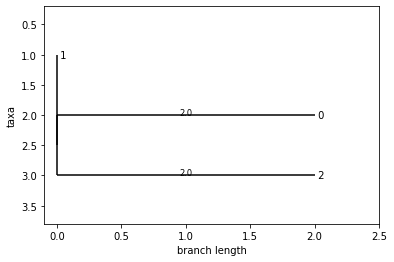

In [386]:
from Bio import Phylo
from io import StringIO

treedata = "((0:2,2:2), 1:0)"
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")
tree.ladderize()
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

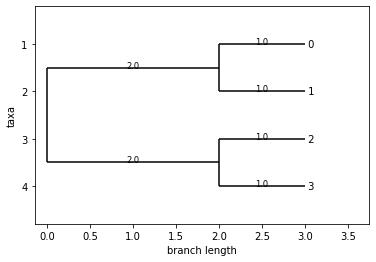

In [387]:
treedata = "((0:1,1:1):2, (2:1,3:1):2)"
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")
tree.ladderize()
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

This method automates the process of the dictionary to newick string. The code was found here on StackOverflow https://stackoverflow.com/questions/50003007/how-to-convert-python-dictionary-to-newick-form-format.

In [388]:
def newickify(node_to_children, root_node) -> str:
    visited_nodes = set()

    def newick_render_node(name, distance: float) -> str:
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, 0) + ';'

    # Ensure no entries in the dictionary are left unused.
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string

The problem with the above algorithm is that it traverses the tree in postorder. Neighbor joining has edges going from parent to child and child to parent, so we must remove child to parent edges or the tree won't be acyclic. Also, we must root the tree. An example is shown below.

((0:1.0,1:1.0)4:2,(2:1.0,3:1.0)5:2)root:0;


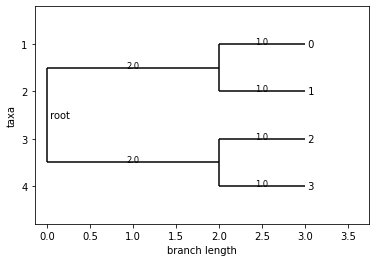

In [389]:
D1 = {
    0: {0:0,1:2,2:4,3:4},
    1: {0:2,1:0,2:4,3:4},
    2: {0:4,1:4,2:0,3:2},
    3: {0:4,1:4,2:2,3:0}
}
T1 = neighbor_join(copy.deepcopy(D1))
del T1[1]
del T1[0]
del T1[3]
del T1[2]
T1['root'] = {4:2, 5:2}
del T1[5][4]
del T1[4][5]


x = newickify(T1, 'root')
print(x)
handle = StringIO(x)
tree = Phylo.read(handle, "newick")
tree.ladderize()
Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

Now, we can simply run neighbor joining, find the newick string and then convert it to a tree we can draw. This overarching algorithm just combines all the steps from above. So, as long as we have a distance matrix, we can now compute a phylogenetic tree. The keys parameter is in case we want to draw the phylogenetic tree with actual names on the leaves. The ascii parameter is there for large phylogenetic trees, which cannot be represented with distances by BioPython (or everything crosses and looks horrible).

In [411]:
def myNeighborJoin(D, keys, ascii = False):
  numLeaves = len(D)
  T = neighbor_join(D)
  top_level = []
  for i in range(numLeaves):
    # if it is top level, it will have 0 distance and we know all leaves have exactly 1 edge
    if list(T[i].values())[0] == 0:
      top_level.append(i)
    del T[i]
  if len(top_level) == 0:
    top_level = (list(T.keys()))[-2:]
    left = top_level[-1]
    right = top_level[-2]
    T['root'] = {}
    if left in T[right]:
      T['root'][left] = T[right][left]
      T['root'][right] = T[right][left]
      del T[left][right]
      del T[right][left]
    else:
      T['root'][left] = 0
      T['root'][right] = 0
    for i in list(T):
      if i == left or i == right or i == 'root':
        continue
      for d in list(T[i]):
        if d > i:
          del T[i][d]
  elif len(top_level) == 1:
    leaf = top_level[0]
    last = list(T.keys())[-1]
    T['root'] = {}
    del T[last][leaf]
    T['root'][last] = 0
    T['root'][leaf] = 0
  x = newickify(T, 'root')
  if keys != None:
    for i, key in enumerate(keys):
      x = x.replace(str(i) + ":", key + ":")
  handle = StringIO(x)
  tree = Phylo.read(handle, "newick")
  tree.ladderize()
  if ascii:
    Phylo.draw_ascii(tree)
  else:
    Phylo.draw(tree, branch_labels=lambda c: c.branch_length)

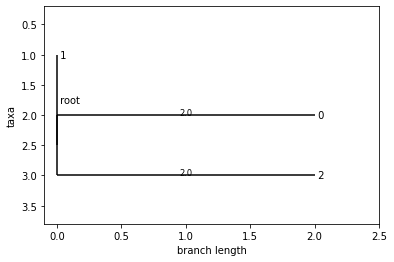

In [412]:
D0 = {
    0: {0:0,1:2,2:4},
    1: {0:2,1:0,2:2},
    2: {0:4,1:2,2:0}
}

myNeighborJoin(D0, None)

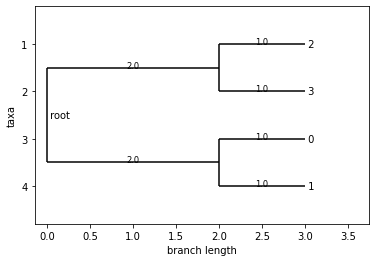

In [413]:
D1 = {
    0: {0:0,1:2,2:4,3:4},
    1: {0:2,1:0,2:4,3:4},
    2: {0:4,1:4,2:0,3:2},
    3: {0:4,1:4,2:2,3:0}
}
myNeighborJoin(D1, None)

Now, all we need is to calculate distance matrices for different datasets of proteins. Blosum62 is a know matrix for scoring alignments and we can use its keys to help us create the basic scoring matrices for distances and for some more complicated metrics as well.

In [414]:
#from hw1
!wget -c 'https://drive.google.com/uc?export=download&id=1rh6Rgjoyloyp2hPhTlOBD16yc7sc3gPy' -O data.zip
!unzip -o data.zip 

def read_blosum62(path):
    """
    Reads in the ncbi's BLOSUM62.txt file and loads the scoring matrix
    into a dictionary.
    
    :param: path is the full path in the local filesystem at which the .txt file is located
    :return: a dictionary of dictionaries which will hold the cost of various amino acid
    substitutions as defined in BLOSUM62.
    """
    delta = {}
    with open(path, 'r') as f:
        lines = f.readlines()[6:]
        keys = lines[0].split()
        keys[-1] = '-'
        for i, line in enumerate(lines[1:]):
            delta[keys[i]] = {k : int(v) for (k,v) in zip(keys, line.split()[1:])}  
    return delta

--2022-12-19 01:12:58--  https://drive.google.com/uc?export=download&id=1rh6Rgjoyloyp2hPhTlOBD16yc7sc3gPy
Resolving drive.google.com (drive.google.com)... 142.250.145.102, 142.250.145.113, 142.250.145.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.145.102|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  data.zip
  inflating: BLOSUM62.txt            
  inflating: Q2b_reference.txt       


Here we create the basic edit distance scoring method, and an edit distance scoring method that discourages gaps between 2 protein sequences. These are the basic methods we will use, along with hamming distance, to see the various phylogenetic trees.

In [415]:
blosum = read_blosum62('./BLOSUM62.txt')

# normal edit distance scoring matrix
aminos = list(blosum.keys())

edit = {}
for a in aminos:
  edit[a] = {}
  for b in aminos:
    if a == b:
      edit[a][b] = 0
    else:
      edit[a][b] = 1
# weighted edit distance penalizing gaps more
editWithGaps = copy.deepcopy(edit)
for amino in aminos:
  editWithGaps['-'][amino] = 2
  editWithGaps[amino]['-'] = 2

We also want some more complicated distance metrics. From BioPython, we know there are many subsituation matrices like Blosum and Pam and we want to see how the various types of scoring mechanisms change our results. Note that these matrices are usually for alignment, which maximizes score, but we want the weighted edit distance, which minimizes score. So, we want to make sure we flip the scoring mechanisms and these matrices and normalize them as distance is nonnegative.

In [416]:
from Bio.Align import substitution_matrices
names = substitution_matrices.load()
metrics = {}

for name in names:
  if name[:6] != "BLOSUM" and name[:3] != "PAM":
    continue
  metrics[name] = {}
  curr = substitution_matrices.load(name)
  m = float('inf')
  for a in aminos:
    x = curr.get(a)
    if a == '-':
      x = curr.get('*')
    if x is None:
      del metrics[name]
      break
    metrics[name][a] = {}
    for b in aminos:
      metrics[name][a][b] = x.get(b)
      if b == '-':
        metrics[name][a][b] = x.get('*')
      metrics[name][a][b] *= -1
      if metrics[name][a][b] < m:
        m = metrics[name][a][b]
  #normalizing
  for a in aminos:
    for b in aminos:
      metrics[name][a][b] -= m
metrics['edit'] = edit
metrics['editWithGaps'] = editWithGaps
metricNames = list(metrics.keys())
print(metricNames)

['BLOSUM45', 'BLOSUM50', 'BLOSUM62', 'BLOSUM80', 'BLOSUM90', 'PAM250', 'PAM30', 'PAM70', 'edit', 'editWithGaps']


This implements the basic weighted distance algorithm from class.

In [417]:
def findPairwiseWeightedEditDist(s1, s2, metric):
  scoring = metrics[metric]
  m=len(s1)+1
  n=len(s2)+1

  dp = [[0] * n for _ in range(m)]
  for i in range(1, m):
    dp[i][0] = scoring[s1[i-1]]['-']
  for i in range(1, n):
    dp[0][i] = scoring['-'][s2[i-1]]
  for i in range(1, m):
      for j in range(1, n):
          dp[i][j] = min(dp[i][j-1]+ scoring['-'][s2[j-1]], 
                         dp[i-1][j]+scoring[s1[i-1]]['-'], 
                         dp[i-1][j-1] + scoring[s1[i-1]][s2[j-1]])
  return dp[m - 1][n - 1]

Now, that the algorithms are set up, we can get some real data and test it. From PFAM/InterPro, we have data here about the Methyl-accepting chemotaxis protein (MCP) signalling domain. We have take a small sample of 9 protein sequences which are in the form of a multiple sequence alginment. Using this website, https://www.ebi.ac.uk/Tools/services/web/toolresult.ebi?jobId=simple_phylogeny-I20221219-021018-0406-22675723-p1m, we can use that multiple sequence alignment on that website to generate what the phylogenetic tree should like. We will use this tree to compare to the trees that are generated from our algorithm. So, we simply read in the alignment, calculate the distance matrix using pairwise distances and run our neighbor joining to draw the phylogenetic tree.

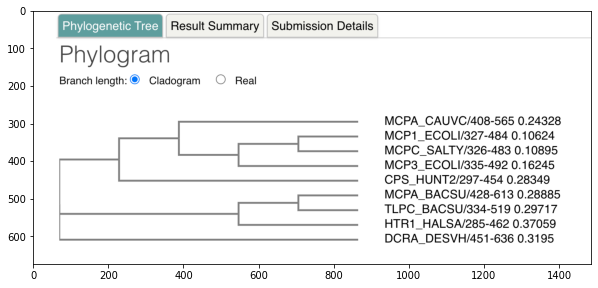

In [435]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('real.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In [444]:
#https://biopython.org/wiki/AlignIO --> reads in alignment files
from Bio import AlignIO

def createDistanceMatrix(filename, metric):
  alignment = AlignIO.read(open(filename), "stockholm")
  keys = []
  alignments = []
  for record in alignment:
    keys.append(record.id)
    alignments.append(record.seq)
  alignments = alignments
  n = len(alignments)
  D = {}
  for i in range(len(alignments)):
    D[i] = {}
  for i in range(len(alignments)):
    for j in range(i + 1, len(alignments)):
      if metric == "hamming":
        D[i][j] = sum(c1 != c2 for c1, c2 in zip(alignments[i], alignments[j]))
        D[j][i] = D[i][j]
        continue
      D[i][j] = findPairwiseWeightedEditDist(alignments[i], alignments[j], metric)
      D[j][i] = D[i][j]
  return D, keys

In [447]:
metricNames.append("hamming")
metricNames = set(metricNames)

In [448]:
for metric in metricNames:
  print( 'METRIC: ' + metric)
  D, keys = createDistanceMatrix("PF00015.alignment.seed", metric)
  myNeighborJoin(D,keys, ascii = True)
  print( '---------------------------------------------------------------------------------\n\n')

METRIC: BLOSUM50
  ______________________________________ HTR1_HALSA/285-462
 |
 |  ___________________________________ MCPA_BACSU/428-613
 |_|
_| |___________________________________ TLPC_BACSU/334-519
 |
 |____________________________________ DCRA_DESVH/451-636
 |
 |    __________________________________ CPS_HUNT2/297-454
 |___|
     |__________________________________ MCPA_CAUVC/408-56MCPA_BACSU/428-613
     |
     |   ________________________________ MCP3_ECOLI/335-492
     |__|
        | ______________________________ MCP1_ECOLI/327-48CPS_HUNT2/297-454
        ||
         |______________________________ MCPC_SALTY/326-483

---------------------------------------------------------------------------------


METRIC: BLOSUM45
  ______________________________________ HTR1_HALSA/285-462
 |
 | ___________________________________ MCPA_BACSU/428-613
 ||
_||____________________________________ TLPC_BACSU/334-519
 |
 |____________________________________ DCRA_DESVH/451-636
 |
 |    _________

We can essentially calculate a ranking here to show the different distance metrics and how effective they are. To do this, we can calculate a difference between the length of the path between every possible pairs of leaves and sum up all those differences to see how off they are. Then we can take the best and worst metrics and see how they perform on a completely new dataset. (This had to be hand calculated as there is no access to the original phylogenetic tree).



1.   Blosum 90 (only scoring mechanism that clearly observed that HTR1\_HALSA was closer to the cluster of the 2 BACSU's than it was to DCRA\_DESVH and got everything else almost perfect)
2.   Blosum 45/50/62/80 and edit/editWithGaps (off by one unable to notice what Blosum 90 did) and Pam70 (just messed up MCPs being next to each other)
3.   Pam30/hamming (mistakes deep in subtree causing for more than off by one errors)
4. Pam250 (could not distinguish many distinct differences, thought most proteins were similar)

All in all the results are not surprising as Blosum works better on local alignments and slightly more distantly related sequences. These bacteria are closely related but this is not the whole sequence and they are still different in evolution so it makes sense why higher # Blosum (local alignining close sequences) performs best and higher # Pam performs the worst (global alignment of more distant sequences)



Now we can run it on a slightly bigger set of proteins to compare the 2.

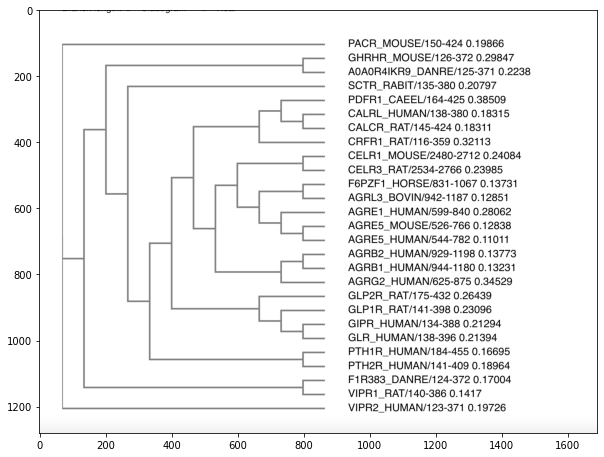

In [449]:
img = mpimg.imread('real2.png')
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In [450]:
print( 'METRIC: BLOSUM90')
D, keys = createDistanceMatrix("PF00002.alignment.seed", metric)
myNeighborJoin(D,keys, ascii = True)
print( '---------------------------------------------------------------------------------\n\n')
print( 'METRIC: PAM250')
D, keys = createDistanceMatrix("PF00002.alignment.seed", metric)
myNeighborJoin(D,keys, ascii = True)
print( '---------------------------------------------------------------------------------\n\n')

METRIC: BLOSUM90
  _____________________ PACR_MOUSE/150-42F1R383_DANRE/124-372
 |
 |____________________ VIPR2_HUMAN/123-371
 |
_| __________________ F1R383_DANRE/124-372
 ,|
 ||__________________ VIPR1_RAT/140-38SCTR_RABIT/135-380
 |
 |____________________ SCTR_RABIT/135-380
 |
 |______________________ GHRHR_MOUSE/126-37A0A0R4IKR9_DANRE/12...
 |
 |____________________ A0A0R4IKR9_DANRE/125-371
 |
 |    ____________________ 2GHRHR_MOUSE/126-37A0A0R4IKR9_DANRE/1...
 | __|
 ||  |____________________ 2A0A0R4IKR9_DANRE/125-371
 ||
 ||  _____________________ 2VIPR2_HUMAN/123-371
 ||_|
  | |_____________________ 2F1R383_DANRE/124-372
  | |
  | | ____________________ 2VIPR1_RAT/140-38SCTR_RABIT/135-380
  | ||
  |  |____________________ 2SCTR_RABIT/135-380
  |
  |  _______________________ 2PACR_MOUSE/150-42F1R383_DANRE/124-372
  | |
  | | _________________________ PDFR1_CAEEL/164-4GIPR_HUMAN/134-388
  |_,|
    ||   ____________________ CALRL_HUMAN/138-380
    ||__|
    |   |____________________